In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../")

from vae_interp.dataset import load_nouns_dataset
import matplotlib.pyplot as plt
from vae_interp.sae import SAE
from vae_interp.vae import VAE
import torch

/home/ubuntu/.cache/pypoetry/virtualenvs/nouns-mech-interp-YeAXWnnL-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset = load_nouns_dataset(image_size=64, normalize=True)

In [4]:
vae = VAE.load_from_dir("../weights/vae")
sae = SAE.load_from_checkpoint("../weights/sae/config.json", "../weights/sae/sae.pth")

vae.eval()
sae.eval()

SAE()

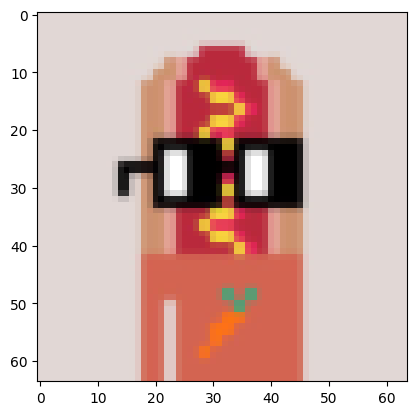

In [5]:
image_id = 0
image = dataset[image_id]

plt.imshow((image.permute(1, 2, 0) + 1) * 0.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.012526631..1.0].


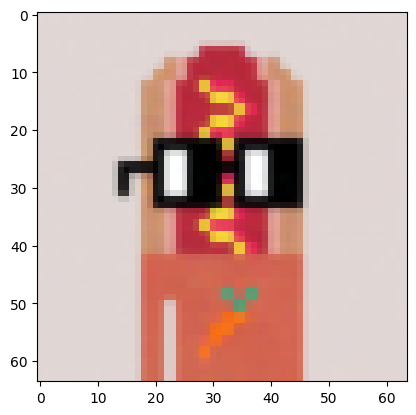

In [6]:
with torch.no_grad():
    recon = vae(image.unsqueeze(0))["recon"].squeeze(0)
    recon = torch.clamp((recon + 1) * 0.5, -1, 1)

plt.imshow(recon.permute(1, 2, 0))

In [7]:
mu, _ = vae.encode(image.unsqueeze(0))
latent = mu.view(1, -1)
features = sae.encode(latent).squeeze(0)
feature_indices = torch.where(features != 0)
activations = features[feature_indices]

features_list = []

for i in range(activations.shape[0]):
    features_list.append({
        "feature_id": int(feature_indices[0][i].item()),
        "activation": activations[i].item()
    })

features_list = sorted(features_list, key=lambda x: x["activation"], reverse=True)
features_list

[{'feature_id': 428, 'activation': 3.2120485305786133},
 {'feature_id': 233, 'activation': 0.6216806769371033},
 {'feature_id': 60, 'activation': 0.599682092666626},
 {'feature_id': 494, 'activation': 0.5987117290496826},
 {'feature_id': 97, 'activation': 0.5738462209701538},
 {'feature_id': 115, 'activation': 0.36907681822776794},
 {'feature_id': 458, 'activation': 0.23255877196788788},
 {'feature_id': 409, 'activation': 0.1675935834646225},
 {'feature_id': 27, 'activation': 0.14473238587379456},
 {'feature_id': 150, 'activation': 0.12043004482984543},
 {'feature_id': 28, 'activation': 0.08183643221855164},
 {'feature_id': 274, 'activation': 0.0691697895526886},
 {'feature_id': 256, 'activation': 0.04976494610309601},
 {'feature_id': 212, 'activation': 0.027281269431114197},
 {'feature_id': 307, 'activation': 0.013926399871706963},
 {'feature_id': 277, 'activation': 0.0010485649108886719}]

In [8]:
image -> vae.encode -> latent -> sae.encode -> features -> sae.decode -> recon_latent -> vae.decode -> recon_image

SyntaxError: invalid syntax (522018518.py, line 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.014710307..1.0].


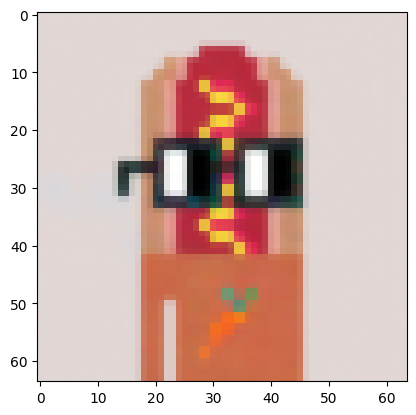

In [9]:
with torch.no_grad():
    recon_latent = sae.decode(features.unsqueeze(0)).view(1, 4, 4, 4)
    recon_image = vae.decode(recon_latent).squeeze(0)
    recon_image = torch.clamp((recon_image + 1) * 0.5, -1, 1)

plt.imshow(recon_image.permute(1, 2, 0))